In [2]:
import pandas as pd
import numpy as np
from notebook_utils.OpenKbcMSToolkit import ExtractionToolkit as exttoolkit

deg_path = "resultFiles/DEG_RRvsCIS_by_Jun/"
expr_path = "../data/counts_normalized/rawFiles/"
deg_df = pd.read_csv(deg_path+"CD4_DEG.result",sep=' ', index_col=0).dropna()
sig_df = deg_df.loc[(deg_df['pvalue']<0.05)]
sig_df = sig_df.loc[(sig_df['log2FoldChange'] > 1) | (sig_df['log2FoldChange'] < -1)]

expr_df = pd.read_csv(expr_path+"counts_norm_CD4.csv", index_col=0)
expr_df.loc[sig_df.index.tolist()]
expr_df.columns = [x.split('.')[0] for x in expr_df.columns.tolist()]
expr_df = expr_df.applymap(lambda x : np.log2(x+1))
expr_df = expr_df.subtract(expr_df.median(axis=1), axis=0)

meta_data = pd.read_csv('../data/annotation_metadata/EPIC_HCvB_metadata_baseline_updated-share.csv')

In [3]:
sample_list, sample_category = exttoolkit.get_sample_name_by_category(dataframe=meta_data, sampleColumn='HCVB_ID', dataColname='DiseaseCourse')
sample_list[0] = list(set(expr_df.columns.tolist()).intersection(set(sample_list[0])))
sample_list[4] = list(set(expr_df.columns.tolist()).intersection(set(sample_list[4])))
ext_samples = sample_list[0] + sample_list[4] # RR + CIS

ext_category = [0]*len(sample_list[0])+[1]*len(sample_list[4])

expr_df = expr_df[ext_samples].loc[sig_df.index]
expr_df = expr_df.replace(0, np.nan).dropna(thresh=len(expr_df.columns)-2).replace(np.nan, 0)


In [4]:
len(ext_samples)

119

In [5]:
X = expr_df.T.values
y = ext_category

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics

auc_arr = []
val_auc = []

for t in list(range(0,100)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=t)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=t)

    #randomState = list(range(0,5))

    clf = SVC(kernel="linear")
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    auc_arr.append([t, metrics.auc(fpr, tpr)])
    
    y_val_pred = clf.predict(X_val)
    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_pred, pos_label=1)
    val_auc.append([t, metrics.auc(fpr, tpr)])

auc_test_df = pd.DataFrame(data=auc_arr, columns=['state', 'auc']).set_index('state')
auc_val_df = pd.DataFrame(data=val_auc, columns=['state', 'auc']).set_index('state')

In [7]:
auc_df = pd.concat([auc_test_df, auc_val_df], axis=1)
auc_df.columns = ['test_auc', 'val_auc']
auc_df['diff'] = auc_df['test_auc'] - auc_df['val_auc']
auc_df

,test_auc,val_auc,diff
state,,,
0,0.718750,0.755556,-0.036806
1,0.708333,0.888889,-0.180556
2,0.626050,0.584034,0.042017
3,0.685714,0.773684,-0.087970
4,0.900000,0.642857,0.257143
...,...,...,...
95,0.750000,0.611888,0.138112
96,0.638655,0.697479,-0.058824
97,0.688889,0.687500,0.001389


/opt/miniconda3/envs/r-py-test/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/r-py-test/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

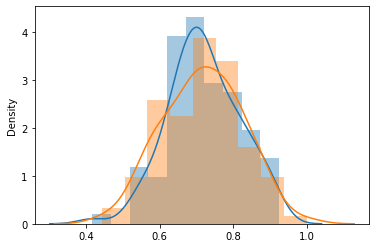

In [8]:
import seaborn as sns
sns.distplot(auc_test_df['auc'].values.tolist())
sns.distplot(auc_val_df['auc'].values.tolist())

/opt/miniconda3/envs/r-py-test/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

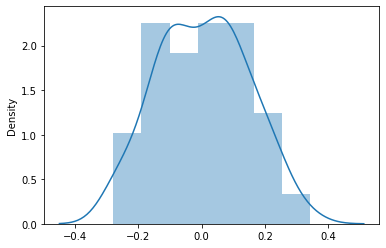

In [9]:
sns.distplot(auc_df['diff'].values.tolist())